# Prédire les habitudes de consommation d'alcool des adolescents

# Sommaire : 

1. [Import et sélection des variables](#sect1)
2. [Transformation des variables et séparation Train / Test](#sect2)
3. [Modélisation](#sect3)
4. [Performance des modèles](#sect4)
5. [Amélioration des hyperparamètres (Grid Search)](#sect5)
6. [Autre modèles et algorithmes](#sect6)


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline

### 1. Import et sélection des vraiables<a name="sect1"></a> 

In [22]:
student = pd.read_csv("https://raw.githubusercontent.com/udacity/machine-learning/master/projects/student_intervention/student-data.csv", sep=",").dropna()
student.rename(columns={'sex':'gender'}, inplace=True)
student['alcohol_index'] = (5*student['Dalc'] + 2*student['Walc'])/7
# Niveau de consommation d'alcool
student['acl'] = student['alcohol_index'] <= 2
student['acl'] = student['acl'].map({True: 'Low', False: 'High'})

In [23]:
student.shape

(395, 33)

In [24]:
student.head(3)

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,passed,alcohol_index,acl
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,no,1.000000,Low
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,no,1.000000,Low
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,yes,2.285714,High


In [25]:
student.dtypes

school            object
gender            object
age                int64
address           object
famsize           object
Pstatus           object
Medu               int64
Fedu               int64
Mjob              object
Fjob              object
reason            object
guardian          object
traveltime         int64
studytime          int64
failures           int64
schoolsup         object
famsup            object
paid              object
activities        object
nursery           object
higher            object
internet          object
romantic          object
famrel             int64
freetime           int64
goout              int64
Dalc               int64
Walc               int64
health             int64
absences           int64
passed            object
alcohol_index    float64
acl               object
dtype: object

In [26]:
# Sélection des variables / features que l'on souhaite conserver pour la prédiction
features = ['gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout','health' ]

In [27]:
student[features].head().T

,0,1,2,3,4
gender,F,F,F,F,F
age,18,17,15,15,16
address,U,U,U,U,U
famsize,GT3,GT3,LE3,GT3,GT3
Pstatus,A,T,T,T,T
Medu,4,1,1,4,3
Fedu,4,1,1,2,3
Mjob,at_home,at_home,at_home,health,other
Fjob,teacher,other,other,services,other
reason,course,course,other,home,home


In [28]:
student[features].head()

,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,no,no,yes,yes,no,no,4,3,4,3
1,F,17,U,GT3,T,1,1,at_home,other,course,...,no,no,no,yes,yes,no,5,3,3,3
2,F,15,U,LE3,T,1,1,at_home,other,other,...,yes,no,yes,yes,yes,no,4,3,2,3
3,F,15,U,GT3,T,4,2,health,services,home,...,yes,yes,yes,yes,yes,yes,3,2,2,5
4,F,16,U,GT3,T,3,3,other,other,home,...,yes,no,yes,yes,no,no,4,3,2,5


#### Descriptif des colonnes : 

* **ADRESS** : student's home address type (binary: 'U' - urban or 'R' - rural) 
* **FAMSIZE** : Family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
* **PSTATUS** Parent's cohabitation status (binary: 'T' - living together or 'A' - living apart)
* **MEDU** (resp. **FEDU**) : Mother's (resp. Father) education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education, or 4 - higher education)
* **MJOB** (resp. **FJOB**): Mother's (resp. Father) job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
* **REASON** : Reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
* **GUARDIAN** : Student's guardian (nominal: 'mother', 'father' or 'other')
* **TRAVELTIME** : Home to school travel time (numeric: 1 - &lt;15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - &gt;1 hour)
* **STUDYTIME** : Weekly study time (numeric: 1 - &lt;2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - &gt;10 hours)
* **FAILURES** :           Number of past class failures (numeric: n if 1&lt;=n&lt;3, else 4)
* **SCHOOLSUP** : Extra educational support (binary: yes or no)
* **FAMSUP** : Family educational support (binary: yes or no)
* **PAID** : Extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
* **ACTIVITIES** : Extra-curricular activities (binary: yes or no) 
* **NURSERY** :  Attended nursery school (binary: yes or no)
* **HIGHER** : Wants to take higher education (binary: yes or no)
* **INTERNET** :  Internet access at home (binary: yes or no)
* **ROMANTIC** : With a romantic relationship (binary: yes or no)
* **FAMREL** : Quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
* **FREETIME** : free time after school (numeric: from 1 - very low to 5 - very high)
* **GOOUT** : Going out with friends (numeric: from 1 - very low to 5 - very high)
* **HEALTH** : Current health status (numeric: from 1 - very bad to 5 - very good)

In [29]:
# Analyse descriptive rapide : 
student[features].describe(include='all')

,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
count,395,395.000000,395,395,395,395.000000,395.000000,395,395,395,...,395,395,395,395,395,395,395.000000,395.000000,395.000000,395.000000
unique,2,NaN,2,2,2,NaN,NaN,5,5,4,...,2,2,2,2,2,2,NaN,NaN,NaN,NaN
top,F,NaN,U,GT3,T,NaN,NaN,other,other,course,...,no,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN
freq,208,NaN,307,281,354,NaN,NaN,141,217,145,...,214,201,314,375,329,263,NaN,NaN,NaN,NaN
mean,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.944304,3.235443,3.108861,3.554430
std,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.896659,0.998862,1.113278,1.390303
min,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000
25%,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,2.000000,3.000000
50%,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,3.000000,4.000000
75%,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,4.000000,4.000000,5.000000


Distinction des variables qualitative / quantitative et identification de la target

In [30]:
# Qualitative :
featuresquali = ['gender','famsize','address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']

# Quantitative :
featuresquanti = ['age', 'Medu','Fedu',  'traveltime', 'studytime',
       'failures',  'famrel', 'freetime', 'goout','health']

# Target
target = 'acl' # consommation d'alcool

In [31]:
student[featuresquali].describe(include='all')

,gender,famsize,address,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,F,GT3,U,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,208,281,307,354,141,217,145,273,344,242,214,201,314,375,329,263


In [32]:
student = student[features + [target]]

## 2. Transformation des variables et séparation Train / Test <a name="sect2"></a> 

In [33]:
# Avant de séparer le Train et le test on "dichotomise" les variables Quali
studentPrep = pd.get_dummies(student[features], columns=featuresquali, drop_first=True) # l'option drop first permet de supprimer une modalité comme référence (Utile dans le cas de la régression logistique)
studentPrep.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,3,...,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,5,3,3,3,...,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,4,3,2,3,...,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,3,2,2,5,...,1,0,0,1,1,1,1,1,1,1
4,16,3,3,1,2,0,4,3,2,5,...,0,0,0,1,1,0,1,1,0,0


On transforme la variable cible en numérique afin que Scikit-learn puisse se situer dans un problème de classification binaire

In [34]:
student['acl'] = student['acl'].map({'Low':0, 'High':1}).astype(int)

In [35]:
# Définition des variables explicatives et de la variable Target
X = studentPrep
y = student[target]

In [36]:
print(len(X),len(y))

395 395


Analyse de la variable cible


In [37]:
# Taux de cible des adolescent ayant une consommation élevée d'alcool 
y.mean()

0.26329113924050634

In [17]:
y.value_counts(normalize=True)

0    0.736709
1    0.263291
Name: acl, dtype: float64

In [18]:
y.describe()

count    395.000000
mean       0.263291
std        0.440978
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: acl, dtype: float64

### Partition train /  test

In [39]:
from sklearn.model_selection import train_test_split 

In [41]:
# Application de la fonction avec tirage de 30% en test
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.3, random_state=42) # stratify permet de conserver la même répartition de la cible

In [42]:
y_train.mean()

0.2644927536231884

In [22]:
y_test.mean()

0.2605042016806723

#### Bonne pratique : feature scaling afin de normaliser les données 

les paramètres de standardisation sont appris sur l'échantillon d'apprentissage et réappliquer sur l'échantillon de test afin de conserver les mêmes transformation de données lors de l'apprentissage du test et de la réapplication sur de nouvelles données

In [44]:
from sklearn.preprocessing import StandardScaler

In [46]:
# Initialisation d'on objet de normalisation 
# Normalisation : moyenne nulle et variance unitaire
scaler = StandardScaler()

In [25]:
X_train[featuresquanti].head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
20,15,4,3,1,2,0,4,4,1,1
177,17,3,3,1,2,0,4,3,4,4
234,16,1,1,2,2,0,3,4,2,5
270,19,3,3,1,2,2,4,3,5,5
107,16,3,3,1,3,0,5,3,3,5


In [47]:
# Entrainement et application de la normalisation sur les données de train 
scaler.fit(X_train[featuresquanti])
X_train[featuresquanti] = scaler.transform(X_train[featuresquanti])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
X_train[featuresquanti].head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
20,-1.354109,1.121946,0.421740,-0.616582,0.008924,-0.470471,0.016461,0.784092,-1.916426,-1.931714
177,0.222828,0.200348,0.421740,-0.616582,0.008924,-0.470471,0.016461,-0.217803,0.759461,0.292847
234,-0.565640,-1.642850,-1.470947,0.766968,0.008924,-0.470471,-1.119351,0.784092,-1.024464,1.034367
270,1.799765,0.200348,0.421740,-0.616582,0.008924,2.075607,0.016461,-0.217803,1.651423,1.034367
107,-0.565640,0.200348,0.421740,-0.616582,1.240429,-0.470471,1.152273,-0.217803,-0.132502,1.034367


In [28]:
X_test[featuresquanti].head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
365,18,1,3,2,2,0,3,3,4,3
84,15,1,1,1,2,0,4,3,2,4
130,15,3,4,2,3,2,4,2,2,5
273,17,1,2,1,2,0,3,5,2,1
27,15,4,2,1,1,0,2,2,4,1


In [48]:
# Réapplication sur les données de test
X_test[featuresquanti] = scaler.transform(X_test[featuresquanti])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
X_test[featuresquanti].head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
365,1.011296,-1.642850,0.421740,0.766968,0.008924,-0.470471,-1.119351,-0.217803,0.759461,-0.448674
84,-1.354109,-1.642850,-1.470947,-0.616582,0.008924,-0.470471,0.016461,-0.217803,-1.024464,0.292847
130,-1.354109,0.200348,1.368084,0.766968,1.240429,2.075607,0.016461,-1.219699,-1.024464,1.034367
273,0.222828,-1.642850,-0.524604,-0.616582,0.008924,-0.470471,-1.119351,1.785988,-1.024464,-1.931714
27,-1.354109,1.121946,-0.524604,-0.616582,-1.222581,-0.470471,-2.255163,-1.219699,0.759461,-1.931714


In [51]:
print(X_train['age'].mean(),X_test['age'].mean())

1.3338766484264561e-15 -0.05545494225240659


# 3. Modélisation <a name="sect3"></a> 

## Modèle de base de la régression logistique

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
# Initialisation de l'objet classifier
classifier_lr = LogisticRegression()

In [55]:
# Apprentissage
classifier_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# Visualisation des coefficients estimées pour chaque variable
coef=list(classifier_lr.coef_[0])
coef_df = pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values))
coef_df.sort_values(['Coefficients'], ascending=False)

,Coefficients
reason_other,1.325924
famsize_LE3,1.036250
goout,0.933291
Fjob_services,0.868780
gender_M,0.489245
paid_yes,0.456338
freetime,0.371790
Fjob_health,0.271802
schoolsup_yes,0.239706
reason_home,0.225768


In [58]:
# Prédiction sur le Train et le Test
probas_train = classifier_lr.predict_proba(X_train) # pour les probas
probas_test = classifier_lr.predict_proba(X_test) # pour les probas

predict_train = classifier_lr.predict(X_train) # pour les prédictions avec cutoff = 0.5
predict_test = classifier_lr.predict(X_test)  # pour les prédictions avec cutoff = 0.5

In [59]:
# Les Probabilités sont celles de 0 et 1 et sont complémentaires
print(classifier_lr.classes_)
probas_test[:5]

[0 1]


array([[0.45774221, 0.54225779],
       [0.9766579 , 0.0233421 ],
       [0.95187037, 0.04812963],
       [0.83934401, 0.16065599],
       [0.42934986, 0.57065014]])

In [60]:
# Récupération uniquement de la proba d'interêt
probas_train = probas_train[:,1]
probas_test = probas_test[:,1]

In [61]:
# Visualisation sur un exemple : 
probas_test[0], y_test.iloc[0]

(0.5422577889634589, 1)

In [39]:
X_test.iloc[0]

age                  1.011296
Medu                -1.642850
Fedu                 0.421740
traveltime           0.766968
studytime            0.008924
failures            -0.470471
famrel              -1.119351
freetime            -0.217803
goout                0.759461
health              -0.448674
gender_M             1.000000
famsize_LE3          0.000000
address_U            0.000000
Pstatus_T            1.000000
Mjob_health          0.000000
Mjob_other           0.000000
Mjob_services        0.000000
Mjob_teacher         0.000000
Fjob_health          0.000000
Fjob_other           1.000000
Fjob_services        0.000000
Fjob_teacher         0.000000
reason_home          0.000000
reason_other         0.000000
reason_reputation    0.000000
guardian_mother      1.000000
guardian_other       0.000000
schoolsup_yes        0.000000
famsup_yes           1.000000
paid_yes             1.000000
activities_yes       0.000000
nursery_yes          1.000000
higher_yes           1.000000
internet_y

# 4. Métriques de performance <a name="sect4"></a> 

### On va utiliser des métriques pour évaluer le modèle
certaines métriques dépendent d'un curseur sur la proba Y=1 (threshold dependant), d'autres au contraire sont comme la logloss une quantité (threshold invariant), c'est le cas de l'AUC qui plus elle est proche de 1 meilleur sera le modèle

In [62]:
# importation de métriques
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,recall_score
import matplotlib.pyplot as plt

In [63]:
# Matrice de confusion
pd.crosstab(y_train, predict_train)

col_0,0,1
acl,,
0,191,12
1,39,34


In [65]:
# Plot confusion matrice plus Visuel : 
# Récupération de la fonction dans les modules
import os
os.chdir('../')
from modules.fonctions_metrics import plot_confusion_matrix

[[191  12]
 [ 39  34]]
[[0.9408867  0.0591133 ]
 [0.53424658 0.46575342]]


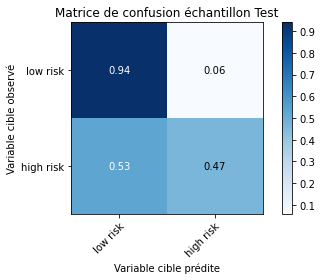

In [43]:
plot_confusion_matrix(y_train, predict_train, classes=["low risk","high risk"], 
                      title='Matrice de confusion échantillon Test')

Compraisons des métriques entre le train et le test

In [66]:
print("Echantillon Train \n ---------")
print(classification_report(y_train, predict_train))

Echantillon Train 
 ---------
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       203
           1       0.74      0.47      0.57        73

    accuracy                           0.82       276
   macro avg       0.78      0.70      0.73       276
weighted avg       0.81      0.82      0.80       276



In [45]:
print("Echantillon Test \n ---------")
print(classification_report(y_test, predict_test))

Echantillon Test 
 ---------
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        88
           1       0.53      0.32      0.40        31

    accuracy                           0.75       119
   macro avg       0.66      0.61      0.62       119
weighted avg       0.72      0.75      0.73       119



##### Tracons les courbes de ROC (compte tenu du peu de volumétrie la forme des courbes n'est pas lisse)

In [67]:
from modules.fonctions_metrics import auc_et_roc

auc= 0.8526891153249206


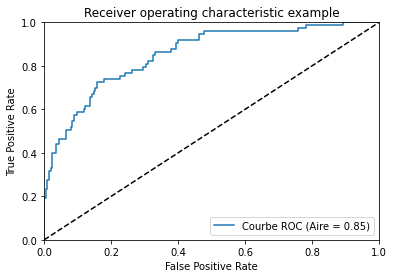

auc= 0.7536656891495601


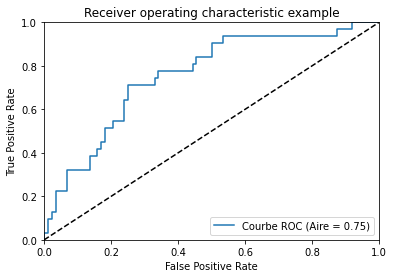

In [68]:
auc_et_roc(y_train,probas_train)
auc_et_roc(y_test,probas_test)

##### Tracons les courbes de Gain et Lift (compte tenu du peu de volumétrie la forme des courbes n'est pas lisse)

In [69]:
from modules.fonctions_metrics import CAP_table, lift 

In [73]:
table_lift = CAP_table(pd.Series(probas_train,index=y_train.index), y_train,stepsize = 1, n=10)
table_lift

,Population,Positifs parmi la population,% positifs,Population cumulée,Positifs cumulés,% Positifs cumulés,% positifs cumulés sur le total des positifs,Lift
1,3,3,100.00,3,3,100.00,4.11,3.78
2,3,3,100.00,6,6,100.00,8.22,3.78
3,2,2,100.00,8,8,100.00,10.96,3.78
4,3,3,100.00,11,11,100.00,15.07,3.78
5,3,3,100.00,14,14,100.00,19.18,3.78
6,3,2,66.67,17,16,94.12,21.92,3.56
7,2,1,50.00,19,17,89.47,23.29,3.38
8,3,3,100.00,22,20,90.91,27.40,3.44
9,3,2,66.67,25,22,88.00,30.14,3.33
10,3,2,66.67,28,24,85.71,32.88,3.24


Text(0, 0.5, '% de scorés à raison')

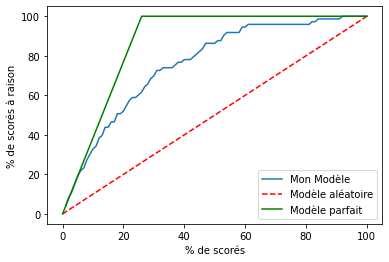

In [50]:
plt.plot(table_lift['% positifs cumulés sur le total des positifs'], label="Mon Modèle")
plt.plot([0, 100], [0, 100], c = 'r', linestyle = '--', label = 'Modèle aléatoire')
plt.plot([0,  np.round(y_train.sum() / len(y_train)*100,0), 100], [0, 100, 100], c = 'g', linestyle = '-', label = 'Modèle parfait')
plt.legend()
plt.xlabel('% de scorés')
plt.ylabel('% de scorés à raison')

Text(0, 0.5, 'Lift')

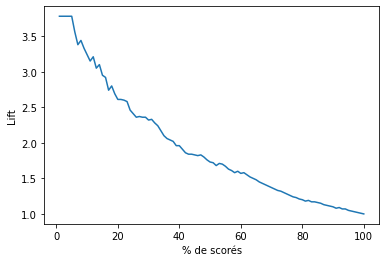

In [51]:
plt.plot(table_lift['Lift'])
plt.xlabel('% de scorés')
plt.ylabel('Lift')

# 5. Amélioration des hyperparamètres (Grid Search) <a name="sect5"></a> 

## Modèle de régression logistique pénalisée

Une régression pénalisée de type ridge (L2) permet de contraindre l'espace des coef estimés pour ne pas qu'ils prennent des valeurs contradictoires et très élevées,
Si la régression est de type lasso (L1) alors certains coefficients vont être annulés.
Le paramètre C contrôle cela : 
C = Inverse of regularization strength; must be a positive float = smaller values specify stronger regularization.

**A noter que dans certaines classes, le paramètre est 1/C**

*NB : Dans Sklearn le coefficient C est égale à l'inverse du poids de régularization*


In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
# On définit la liste des hyper paramètres de l'on souhaite tester
param = [{ "C": [0.01,0.025,0.05,0.1],"class_weight": ["balanced", None] }]

# On initialise un objet classifier LR sur lequel nous allons tester toutes les itérations possibles
clf_lr=LogisticRegression(penalty='l1', solver="liblinear")

# On initialise un objet gridsearch grâce à la liste d'arguments et au classifier 
# on lui donne une métrique à maximiser pour identifier le meilleur modèle
# on spécifie sur combien d'échantillon de cross validation se fera le calcul des métriques (cv)  
modelCV= GridSearchCV(clf_lr, param, cv = 4, n_jobs = -1, scoring='recall')


In [76]:
# On lance l'entraînement de tous les modèles
modelCV = modelCV.fit(X_train, y_train)

In [77]:
# Résultats détaillés :
pd.DataFrame(modelCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003171,0.001056,0.001837,0.000252,0.01,balanced,"{'C': 0.01, 'class_weight': 'balanced'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
1,0.002133,0.000026,0.001774,0.000358,0.01,None,"{'C': 0.01, 'class_weight': None}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
2,0.002439,0.000213,0.001602,0.000255,0.025,balanced,"{'C': 0.025, 'class_weight': 'balanced'}",0.000000,0.611111,0.722222,0.684211,0.504386,0.293932,3
3,0.002107,0.000044,0.001442,0.000007,0.025,None,"{'C': 0.025, 'class_weight': None}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
4,0.004565,0.002229,0.001507,0.000050,0.05,balanced,"{'C': 0.05, 'class_weight': 'balanced'}",0.666667,0.611111,0.722222,0.684211,0.671053,0.040011,2
5,0.002449,0.000192,0.001505,0.000118,0.05,None,"{'C': 0.05, 'class_weight': None}",0.055556,0.055556,0.222222,0.210526,0.135965,0.080516,5
6,0.002344,0.000017,0.001472,0.000013,0.1,balanced,"{'C': 0.1, 'class_weight': 'balanced'}",0.666667,0.666667,0.722222,0.736842,0.698099,0.031855,1
7,0.002432,0.000059,0.001425,0.000011,0.1,None,"{'C': 0.1, 'class_weight': None}",0.166667,0.277778,0.277778,0.210526,0.233187,0.047210,4


In [78]:
# Quel sont les meilleurs paramètres ? 
modelCV.best_params_

{'C': 0.1, 'class_weight': 'balanced'}

In [57]:
# Meilleur estimator
modelCV.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
# Visualisation des coefficients estimées pour chaque variable
coef=list(modelCV.best_estimator_.coef_[0])
coef_df = pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values))

coef_df.sort_values(['Coefficients'], ascending=False)

,Coefficients
goout,0.627740
freetime,0.138381
failures,0.087935
traveltime,0.069167
famsize_LE3,0.035127
health,0.013265
age,0.000000
famsup_yes,0.000000
reason_other,0.000000
reason_reputation,0.000000


In [80]:
# L'argument refit=True permet de réentrainer directement le meilleur estimator à la fin de l'entrainement du Grid Search
# on a donc pas besoin de ré-entraîner un modèle mais on peut directement utiliser l'objet modelCV
# Dans le cas où le best_estimator_ ne nous convient pas il faudrait entraîner un nouveau modèle avec les paramètres voulus

predict_train = modelCV.predict(X_train)
predict_test = modelCV.predict(X_test)
probas_train = modelCV.predict_proba(X_train)[:,1]
probas_test = modelCV.predict_proba(X_test)[:,1]


#### Evaluation des performances

In [81]:
print("Echantillon Train \n ---------")
print(classification_report(y_train, predict_train))

Echantillon Train 
 ---------
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       203
           1       0.46      0.70      0.56        73

    accuracy                           0.71       276
   macro avg       0.67      0.70      0.67       276
weighted avg       0.76      0.71      0.72       276



In [82]:
print("Echantillon Test \n ---------")
print(classification_report(y_test, predict_test))

Echantillon Test 
 ---------
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        88
           1       0.40      0.55      0.46        31

    accuracy                           0.66       119
   macro avg       0.61      0.63      0.61       119
weighted avg       0.71      0.66      0.68       119



auc= 0.7675956542276807


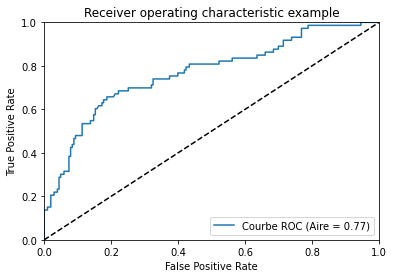

auc= 0.7140762463343109


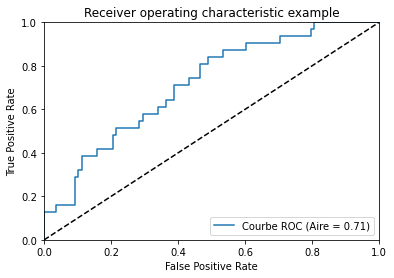

In [83]:
auc_et_roc(y_train,probas_train)
auc_et_roc(y_test,probas_test)

# 6. Autre modèles et algorithmes <a name="sect6" ></a>

### Arbre CART

In [84]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
modele_arbre=DecisionTreeClassifier(random_state = 42, max_depth = 3, min_samples_leaf = 30)

In [87]:
modele_arbre.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [88]:
predict_train = modele_arbre.predict(X_train)
predict_test = modele_arbre.predict(X_test)
probas_train = modele_arbre.predict_proba(X_train)[:,1]
probas_test = modele_arbre.predict_proba(X_test)[:,1]


In [89]:
print("Echantillon Train \n ---------")
print(classification_report(y_train, predict_train))

print("Echantillon Test \n ---------")
print(classification_report(y_test, predict_test))

Echantillon Train 
 ---------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       203
           1       0.62      0.47      0.53        73

    accuracy                           0.78       276
   macro avg       0.72      0.68      0.69       276
weighted avg       0.77      0.78      0.77       276

Echantillon Test 
 ---------
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        88
           1       0.69      0.35      0.47        31

    accuracy                           0.79       119
   macro avg       0.75      0.65      0.67       119
weighted avg       0.78      0.79      0.76       119



[Text(620.0, 951.3000000000001, 'goout <= 0.313\ngini = 0.389\nsamples = 100.0%\nvalue = [0.736, 0.264]\nclass = y[0]'),
 Text(372.0, 679.5, 'famsize_LE3 <= 0.5\ngini = 0.236\nsamples = 63.8%\nvalue = [0.864, 0.136]\nclass = y[0]'),
 Text(248.0, 407.70000000000005, 'Fjob_services <= 0.5\ngini = 0.154\nsamples = 47.5%\nvalue = [0.916, 0.084]\nclass = y[0]'),
 Text(124.0, 135.89999999999998, 'gini = 0.084\nsamples = 33.0%\nvalue = [0.956, 0.044]\nclass = y[0]'),
 Text(372.0, 135.89999999999998, 'gini = 0.289\nsamples = 14.5%\nvalue = [0.825, 0.175]\nclass = y[0]'),
 Text(496.0, 407.70000000000005, 'gini = 0.411\nsamples = 16.3%\nvalue = [0.711, 0.289]\nclass = y[0]'),
 Text(868.0, 679.5, 'gender_M <= 0.5\ngini = 0.5\nsamples = 36.2%\nvalue = [0.51, 0.49]\nclass = y[0]'),
 Text(744.0, 407.70000000000005, 'gini = 0.444\nsamples = 16.3%\nvalue = [0.667, 0.333]\nclass = y[0]'),
 Text(992.0, 407.70000000000005, 'gini = 0.472\nsamples = 19.9%\nvalue = [0.382, 0.618]\nclass = y[1]')]

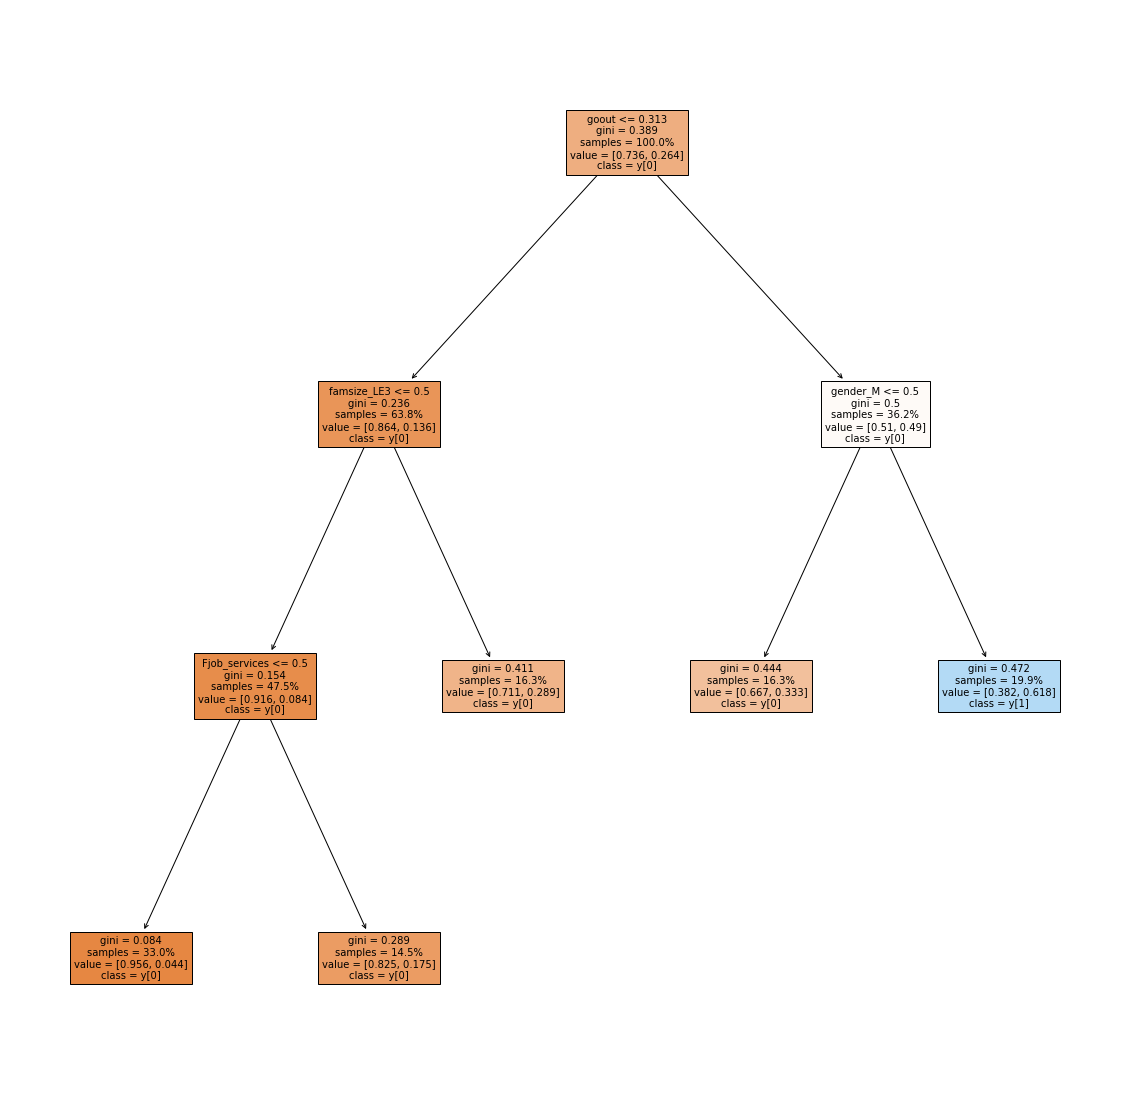

In [90]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(modele_arbre,class_names=True, max_depth=4,proportion=True, fontsize=10,filled=True,feature_names=X_train.columns) 

## Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300, max_depth = 3,min_samples_leaf = 30, random_state = 42, class_weight="balanced" )    
rf.fit(X_train, y_train)
predict_train = rf.predict(X_train)
predict_test = rf.predict(X_test)
probas_train = rf.predict_proba(X_train)[:,1]
probas_test = rf.predict_proba(X_test)[:,1]

In [93]:
print("Echantillon Train \n ---------")
print(classification_report(y_train, predict_train))

print("Echantillon Test \n ---------")
print(classification_report(y_test, predict_test))

Echantillon Train 
 ---------
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       203
           1       0.62      0.74      0.68        73

    accuracy                           0.81       276
   macro avg       0.76      0.79      0.77       276
weighted avg       0.83      0.81      0.82       276

Echantillon Test 
 ---------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        88
           1       0.39      0.39      0.39        31

    accuracy                           0.68       119
   macro avg       0.59      0.59      0.59       119
weighted avg       0.68      0.68      0.68       119



In [95]:
pd.DataFrame([X_train.columns,rf.feature_importances_]).T.sort_values([1],ascending=False)

,0,1
8,goout,0.245554
7,freetime,0.0714683
3,traveltime,0.0512763
5,failures,0.0496275
11,famsize_LE3,0.0472511
0,age,0.0441614
4,studytime,0.0438455
9,health,0.0420983
23,reason_other,0.0419585
10,gender_M,0.0398245


auc= 0.8146973479991902


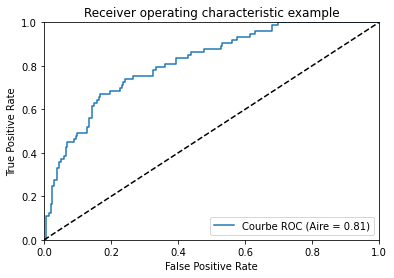

auc= 0.6796187683284458


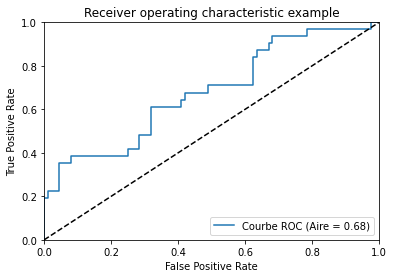

In [98]:
auc_et_roc(y_train,probas_train)
auc_et_roc(y_test,probas_test)

### GBM (Gradient Boosting Machine) 

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
gbm =GradientBoostingClassifier(learning_rate=0.01,
                           n_estimators=400, max_depth=2, random_state=42,subsample=0.9 )
gbm.fit(X_train, y_train)
predict_train = gbm.predict(X_train)
predict_test = gbm.predict(X_test)
probas_train = gbm.predict_proba(X_train)[:,1]
probas_test = gbm.predict_proba(X_test)[:,1]

In [73]:
print("Echantillon Train \n ---------")
print(classification_report(y_train, predict_train))

print("Echantillon Test \n ---------")
print(classification_report(y_test, predict_test))

Echantillon Train 
 ---------
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       203
           1       0.90      0.52      0.66        73

    accuracy                           0.86       276
   macro avg       0.88      0.75      0.79       276
weighted avg       0.86      0.86      0.84       276

Echantillon Test 
 ---------
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        88
           1       1.00      0.23      0.37        31

    accuracy                           0.80       119
   macro avg       0.89      0.61      0.62       119
weighted avg       0.84      0.80      0.75       119



In [74]:
pd.DataFrame([X_train.columns,gbm.feature_importances_]).T.sort_values([1],ascending=False)

,0,1
8,goout,0.387635
23,reason_other,0.075906
11,famsize_LE3,0.073271
3,traveltime,0.071684
1,Medu,0.070643
10,gender_M,0.059975
7,freetime,0.039616
20,Fjob_services,0.033842
12,address_U,0.028527
5,failures,0.026653
